In [3]:
#import necessary libraries

import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
import unidecode
import html

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix


from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import load_model

# Apple Tweet Sentiment Analysis
## Modeling Notebook

Author: Dylan Dey

This project it available on github here: link

The Author can be reached at the following email: ddey2985@gmail.com

Blog: blog link

#### Classification Metric Understanding
![](images/Apple_Twitter_matrix_explained.jpg)

#### Confusion Matrix Description

A true positive in the current context would be when the model correctly identifies a tweet with positive sentiment as positive. A true negative would be when the model correctly identifies a tweet with negative sentiment as containing negative sentiment. Both are important and both can be described by the overall accuracy of the model.

True negatives are really at the heart of the model, as this is the situation in which Apple would have a call to action. An appropriately identified tweet with negative sentiment can be properly examined using some simple NLP techniques to get a better understanding at what is upsetting customers involved with our brand and competitor's brands. Bigrams, quadgrams, and other word frequency analysis can help Apple to address brand concerns. 

True positives are also important. Word frequency analysis can be used to summarize what consumers think Apple is doing right and also what consumers like about Apple's competitors. 

There will always be some error involved in creating a predictive model. The model will incorrectly identify positive tweets as negative and vice versa. That means the error in any classification model in this context can be described by ratios of true positives or negatives vs false positives or negatives.

A false positive would occur when the model incorrectly identifies a tweet containing negative sentiment as a tweet that contains positive sentiment. Given the context of the business model, this would mean more truly negative sentiment will be left out of analyzing key word pairs for negative tweets. This could be interpreted as loss in analytical ability for what we care about most given the buisness problem: making informed decisions from information directly from consumers in the form of social media text. Minimizing false positives is very important.

False negatives are also important to consider. A false negative would occur when the model incorrectly identifies a tweet that contains positive sentiment as one that contains negative sentiment. Given the context of the business problem, this would mean extra noise added to the data when trying to isolate for negative sentiment of brand/product. 

In summary, overall accuracy of the model and a reduction of both false negatives and false positives are the most important metrics to consider when developing the sentiment analyisis model.

### Function Definition

In [4]:
#list of all functions for modeling
#and processing

#force lowercase of text data
def lower_case_text(text_series):
    text_series = text_series.apply(lambda x: str.lower(x))
    return text_series

#remove URL links from text
def strip_links(text):
    link_regex = re.compile('((https?):((\/\/)|(\\\\))+([\w\d:#@%\/;$()~_?\+-=\\\.&](#!)?)*)|{link}/gm')
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

#remove '@' and '#' symbols from text
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

#tokenize text and remove stopwords
def process_text(text):
    tokenizer = TweetTokenizer()
    
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    stopwords_list += ["''", '""', '...', '``']
    my_stop = ["#sxsw",
               "sxsw",
               "sxswi",
               "#sxswi's",
               "#sxswi",
               "southbysouthwest",
               "rt",
               "tweet",
               "tweet's",
               "twitter",
               "austin",
               "#austin",
               "link",
               "1/2",
               "southby",
               "south",
               "texas",
               "@mention",
               "ï",
               "ï",
               "½ï",
               "¿",
               "½",
               "link", 
               "via", 
               "mention",
               "quot",
               "amp",
               "austin"
              ]

    stopwords_list +=  my_stop 
    
    tokens = tokenizer.tokenize(text)
    stopwords_removed = [token for token in tokens if token not in stopwords_list]
    return stopwords_removed
    


#master preprocessing function
def Master_Pre_Vectorization(text_series):
    text_series = lower_case_text(text_series)
    text_series = text_series.apply(strip_links).apply(strip_all_entities)
    text_series = text_series.apply(unidecode.unidecode).apply(html.unescape)
    text_series =text_series.apply(process_text)
    lemmatizer = WordNetLemmatizer()
    text_series = text_series.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return text_series.str.join(' ').copy()


#function for intepreting results of models
#takes in a pipeline and training data
#and prints cross_validation scores 
#and average of scores


def cross_validation(pipeline, X_train, y_train):
    scores = cross_val_score(pipeline, X_train, y_train)
    agg_score = np.mean(scores)
    print(f'{pipeline.steps[1][1]}: Average cross validation score is {agg_score}.')


#function to fit pipeline
#and return subplots 
#that show normalized and 
#regular confusion matrices
#to easily intepret results
def plot_confusion_matrices(pipe, pathway):
    
    pipe.fit(X_train, y_train)
    y_true = y_test
    y_pred = pipe.predict(X_test)

    matrix_norm = confusion_matrix(y_true, y_pred, normalize='true') 
    matrix = confusion_matrix(y_true, y_pred) 

    fig, (ax1, ax2) = plt.subplots(ncols = 2,figsize=(10, 5))
    sns.heatmap(matrix_norm,
                annot=True, 
                fmt='.2%', 
                cmap='YlGn',
                xticklabels=['Pos_predicted', 'Neg_predicted'],
                yticklabels=['Positive Tweet', 'Negative_Tweet'],
                ax=ax1)
    sns.heatmap(matrix,
                annot=True, 
                cmap='YlGn',
                fmt='d',
                xticklabels=['Pos_predicted', 'Neg_predicted'],
                yticklabels=['Positive Tweet', 'Negative_Tweet'],
                ax=ax2)
    
    plt.savefig(pathway)
    
    plt.show();
    


    
#loads a fitted model from memory 
#returns confusion matrix and
#returns normalized confusion matrix
#calculated using given test data
def confusion_matrix_bert_plots(model_path, X_test, y_test, fig_pathway):
    
    model = load_model(model_path)
    
    y_pred = model.predict(X_test)

    matrix_norm = confusion_matrix(y_test, y_pred, normalize='true')

    matrix = confusion_matrix(y_test, y_pred)

    fig, (ax1, ax2) = plt.subplots(ncols = 2,figsize=(10, 5))
    sns.heatmap(matrix_norm,
                annot=True, 
                fmt='.2%', 
                cmap='YlGn',
                xticklabels=['Pos_predicted', 'Neg_predicted'],
                yticklabels=['Positive Tweet', 'Negative_Tweet'],
                ax=ax1)
    sns.heatmap(matrix,
                annot=True, 
                cmap='YlGn',
                fmt='d',
                xticklabels=['Pos_predicted', 'Neg_predicted'],
                yticklabels=['Positive Tweet', 'Negative_Tweet'],
                ax=ax2)
    
    plt.savefig(fig_pathway);
    plt.show();

In [5]:
#import cleaned dataset
df = pd.read_csv('data/clean_df.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

# X = df['tweet'].str.join(' ').copy()
X = df['tweet'].copy()
y = df['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#clean and prepare data
#for TF_IDF vector transformation
X_train = Master_Pre_Vectorization(X_train)
X_test = Master_Pre_Vectorization(X_test)

#vecorize text data
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

In [6]:
X_train

1429    google building real time engine monitor illeg...
67                                          haz ifrom gr8
1703    yup apple come cool technology one ever heard ...
3819                               u used b cool happened
221     think fell bit love today thanks throwing nerd...
                              ...                        
1238                   pollak much trouble sell apple duh
466     new whrrl app live iphone app store android ma...
3092    wait anymore google launch major new social ne...
3772    dear ever lovin heck put navigation arrow itun...
860                       awesome traded last year ipad 1
Name: tweet, Length: 3280, dtype: object

In [7]:
vectorizer = TfidfVectorizer()

#multinomial bayes classifier
nb_classifier = MultinomialNB()
NB_pipe = make_pipeline(vectorizer, nb_classifier)
cross_validation(NB_pipe, X_train, y_train)
#random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_pipe = make_pipeline(vectorizer, rf_classifier)
cross_validation(rf_pipe, X_train, y_train)
#balanced random forest classifier
balanced_rf_classifier = BalancedRandomForestClassifier(n_estimators=100)
balanced_rf_pipe = make_pipeline(vectorizer, balanced_rf_classifier)
cross_validation(balanced_rf_pipe, X_train, y_train)
#XGBoosted classifier
xgb_classifier = XGBClassifier()
xgb_pipe = make_pipeline(vectorizer, xgb_classifier)
cross_validation(xgb_pipe, X_train, y_train)

MultinomialNB(): Average cross validation score is 0.8134146341463415.
RandomForestClassifier(): Average cross validation score is 0.8661585365853659.
BalancedRandomForestClassifier(): Average cross validation score is 0.8442073170731706.
XGBClassifier(): Average cross validation score is 0.8033536585365854.


In [70]:
pipes = [NB_pipe,
         rf_pipe,
         balanced_rf_pipe,
         xgb_pipe
        ]

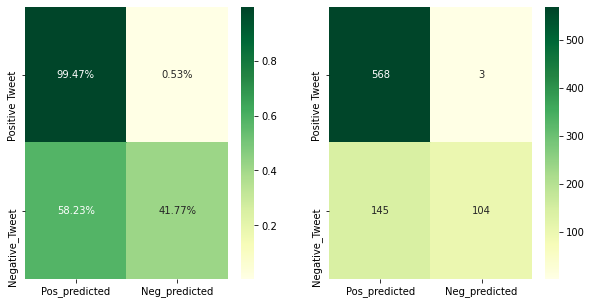

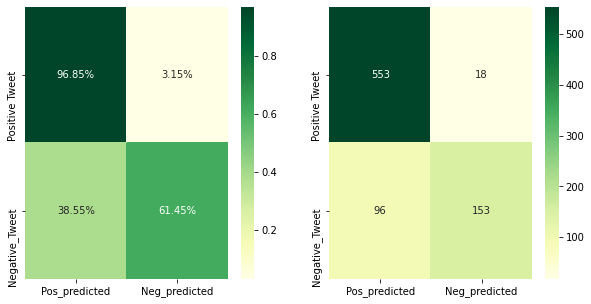

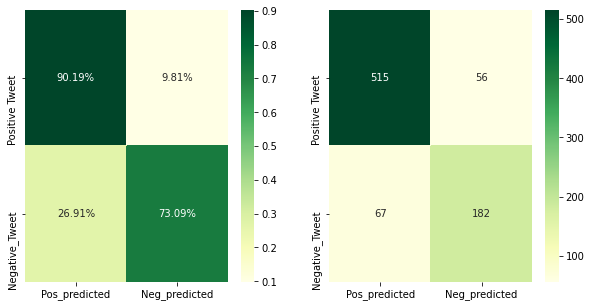

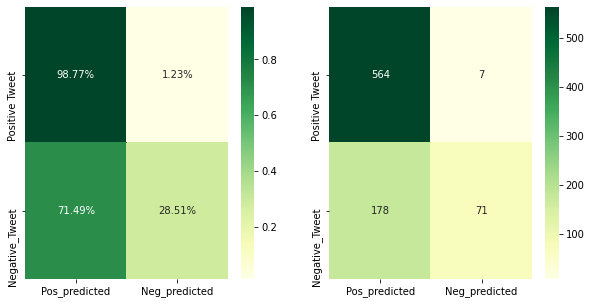

In [82]:
pathways = ['images/XGBoosted_matrix',
            'images/balanced_RF_matrix',
            'images/RF_matrix', 
            'images/NB_matrix'
           ]


for pipe in pipes:
    pathway = pathways.pop()
    plot_confusion_matrices(pipe, pathway)   

Fitting 3 folds for each of 1667 candidates, totalling 5001 fits


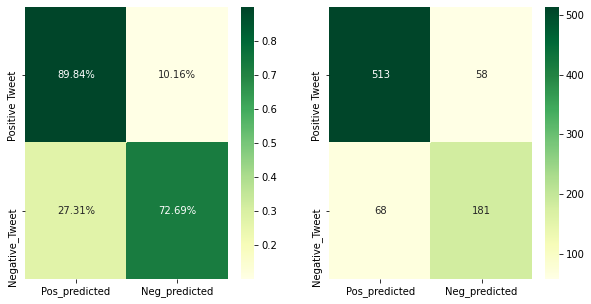

In [7]:
#initialize grid search variables
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
criterion = ["gini", "entropy"]
min_samples_split = [8, 10, 12]
max_depth = [int(x) for x in np.linspace(10, 1000, num = 10)] 
min_samples_leaf = [0.01, 0.1, 1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

#rrandomly iterate 1667*3 times through the grid
balanced_rfc_rs = RandomizedSearchCV(estimator = BalancedRandomForestClassifier(), 
                                     param_distributions = random_grid,
                                     n_iter = 1667,
                                     cv = 3,
                                     verbose=2,
                                     random_state=11,
                                     n_jobs = -1
                                    )


#fit random grid search and determine best_estimator_
balanced_rfc_rs.fit(tf_idf_X_train, y_train)

#create pipeline for best result from random grid search
balanced_rfc_rs_pipe = make_pipeline(vectorizer, 
                                     balanced_rfc_rs.best_estimator_)

plot_confusion_matrices(balanced_rfc_rs_pipe)

Now that supervised learning models have been built, trained, and tuned without any pre-training, our focus will now turn to transfer learning using Bidirectional Encoder Representations from Transformers(BERT), developed by Google. BERT is a transformer-based machine learning technique for natural language processing pre-training. BERTBASE models are pre-trained from unlabeled data extracted from the BooksCorpus with 800M words and English Wikipedia with 2,500M words. 

[Click Here for more from Wikipedia](https://en.wikipedia.org/wiki/BERT_(language_model))

[GitHub for BERT release code](https://github.com/google-research/bert)

Sckit-learn wrapper provided by Charles Nainan. [GitHub of Scikit Learn BERT wrapper](https://github.com/charles9n/bert-sklearn). 


This scikit-learn wrapper is used to finetune Google's BERT model and is built on the huggingface pytorch port.

In [10]:
"""
The first model was fitted as seen commeted out below 
after some trial and error to determine an appropriate
max_seq_length given my computer's capibilities. 

"""


# bert_1 = BertClassifier(do_lower_case=True,
#                       train_batch_size=32,
#                       max_seq_length=50
#                      )



"""
My second model contains 2 hidden layers with 600 neurons. 
It only passes over the corpus one time when learning.
It trains fast and gives impressive results.

"""


# bert_2 = BertClassifier(do_lower_case=True,
#                       train_batch_size=32,
#                       max_seq_length=50,
#                       num_mlp_hiddens=500,
#                       num_mlp_layers=2,
#                       epochs=1
#                      )

"""
My third bert model has 600 neurons still but
only one hidden layer. However, the model
passes over the corpus 4 times in total
while learning.

"""

# bert_3 = BertClassifier(do_lower_case=True,
#                       train_batch_size=32,
#                       max_seq_length=50,
#                       num_mlp_hiddens=600,
#                       num_mlp_layers=1,
#                       epochs=4
#                      )

"""
My fourth bert model has 750 neurons and 
two hidden layers. The corpus also gets
transversed four times in total while 
learning.

"""

# bert_4 = BertClassifier(do_lower_case=True,
#                       train_batch_size=32,
#                       max_seq_length=50,
#                       num_mlp_hiddens=750,
#                       num_mlp_layers=2,
#                       epochs=4
#                      )

'\nMy second model contains 2 hidden layers with 600 neurons. \nIt only passes over the corpus one time when learning.\nIt trains fast and gives impressive results.\n\n'

In [13]:
# def plot_confusion_matrices(pipe, pathways):
    
#     pipe.fit(X_train, y_train)
#     y_true = y_test
#     y_pred = pipe.predict(X_test)

#     matrix_norm = confusion_matrix(y_true, y_pred, normalize='true') 
#     matrix = confusion_matrix(y_true, y_pred) 

#     fig, (ax1, ax2) = plt.subplots(ncols = 2,figsize=(10, 5))
#     sns.heatmap(matrix_norm,
#                 annot=True, 
#                 fmt='.2%', 
#                 cmap='YlGn',
#                 xticklabels=['Pos_predicted', 'Neg_predicted'],
#                 yticklabels=['Positive Tweet', 'Negative_Tweet'],
#                 ax=ax1)
#     sns.heatmap(matrix,
#                 annot=True, 
#                 cmap='YlGn',
#                 fmt='d',
#                 xticklabels=['Pos_predicted', 'Neg_predicted'],
#                 yticklabels=['Positive Tweet', 'Negative_Tweet'],
#                 ax=ax2)
    
#     if pathways:
#         for pathway in pathways:
#             plt.savefig(pathway)

#     plt.show();

Loading model from data/bert_model_1.bin...


02/08/2022 16:51:45 - INFO - bert_sklearn.model.pytorch_pretrained.modeling -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



Defaulting to linear classifier/regressor
Building sklearn text classifier...


Predicting: 100%|██████████| 103/103 [01:27<00:00,  1.18it/s]


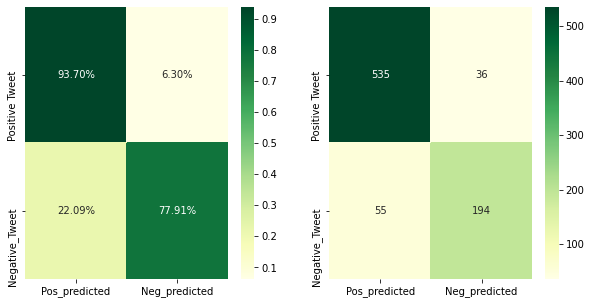

Loading model from data/bert_model_2.bin...
Using mlp with D=768,H=500,K=2,n=2
Building sklearn text classifier...


Predicting: 100%|██████████| 103/103 [01:26<00:00,  1.19it/s]


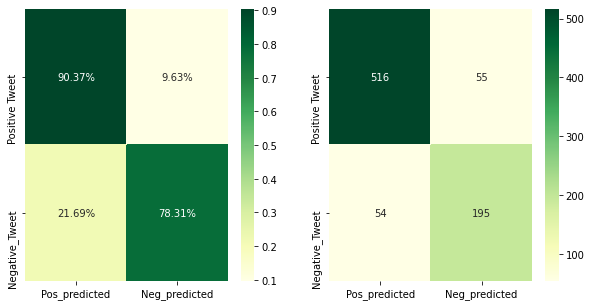

Loading model from data/bert_model_3.bin...
Using mlp with D=768,H=600,K=2,n=1
Building sklearn text classifier...


Predicting: 100%|██████████| 103/103 [01:27<00:00,  1.17it/s]


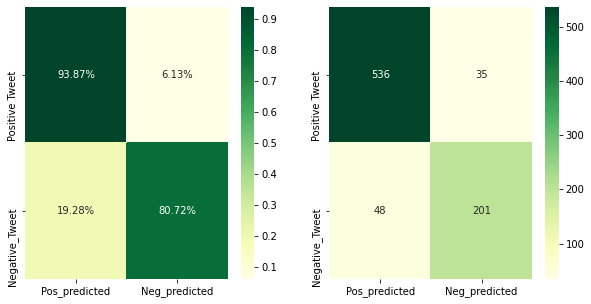

Loading model from data/bert_model_4.bin...
Using mlp with D=768,H=750,K=2,n=2
Building sklearn text classifier...


Predicting: 100%|██████████| 103/103 [01:27<00:00,  1.18it/s]


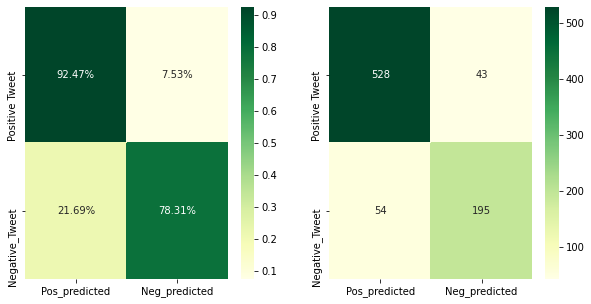

In [8]:
#Review confusion matrix plots
#For all bert models saved in memory

bert_paths= ['data/bert_model_1.bin', 
             'data/bert_model_2.bin', 
             'data/bert_model_3.bin',
             'data/bert_model_4.bin'
            ]

figure_paths = ['images/bert4_matrix.jpg',
                'images/bert3_matrix.jpg',
                'images/bert2_matrix.jpg',
                'images/bert1_matrix.jpg',
               ]

for bert_path in bert_paths:
    figure_path = figure_paths.pop()
    confusion_matrix_bert_plots(bert_path, X_test, y_test, figure_path)

The best performing model was the BERT Classifier, trained by transversing the corpus 4 times in total with one hidden layer and 600 neurons. 

The classifier was able to correctly predict over 80% of negative tweets correctly, which is really impressive given the imbalance in the original data. It also correctly identifies positive tweets nearly 92.50% of the time.

Model 3 has the lowest false negative rate at 19.28%. 

The BERT classifier could be used in tandum with regex queries to track down more tweet data about Apple or a competitor and continue to extract actionable insights straight from consumers in a streamlined and simplified manner.